# Meme Stocks - Stock Market Analysis

We will analyze stock price, returns, and trading volume data of the two key "meme stocks" in 2021. The companies AMC Theatres (AMC) and GameStop (GME) saw surprising growth and trading activity in 2021, led partly by online trading communities. We will take a deep dive into their financial data and put it in context of the markets, as measured through the S&P 500 and Russell 3000 indices. 

Both companies proved to be significant outliers within the markets and were characterized as "meme stocks" early on. We will go through the technical process on how to analyze the data in Python, using Yahoo Finance as our data source, Pandas and Numpy for data analysis, Matplotlib for visualization, and Scikit-learn for machine learning.

This project will focus on the below questions:

- What was the change in stock price over time? How much of an outlier were AMC and GME?
- What was the daily return average of the companies?
- What were the cumulative returns over time, how do the companies compare?
- What were their 30-day moving averages?
- What was the correlation of the meme stocks with the wider market?
- How can we use the trading volume to try to predict the daily returns? 

In [776]:
# Importing pandas and numpy for data analysis
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import math

# Importing pandas tools for data
import pandas_datareader as pdr
from pandas_datareader import data as web
from datetime import datetime
pd.set_option('display.max_rows', 10)

# Importing Matplotlib for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.style.use('fivethirtyeight')

# Importing Scikit-learn for ML tools
from sklearn.linear_model import LinearRegression

#### Importing the data from Yahoo

First, we have to import the financial data of our meme stocks and indices, which will represent the markets. We will use both the S&P 500 and Russell 3000 indices, and set the timeframe to the 2021 calendar year.

In [777]:
data_source = 'yahoo'
meme_stocks_list = ['AMC','GME']
# SPY: S&P 500, IWV: Russell 3000
index_list = ['SPY','IWV'] 

end = datetime(2021,12,31)
start = datetime(2020,12,31)

Grabbing the data from Yahoo, saving it into a dataframe.

In [778]:
df = pd.DataFrame()
for stock in meme_stocks_list:
    df_tmp = web.DataReader(stock, data_source = data_source, start = start, end = end)
    df_tmp['Ticker'] = stock
    df = pd.concat([df, df_tmp])

for index in index_list:
    df_tmp = web.DataReader(index, data_source = data_source, start = start, end = end)
    df_tmp['Ticker'] = index
    df = pd.concat([df, df_tmp])

# Resetting the index to turn date into a column
df = df.reset_index()
df

,Date,High,Low,Open,Close,Volume,Adj Close,Ticker
0,2020-12-31,2.220000,2.080000,2.170000,2.120000,28234300.0,2.120000,AMC
1,2021-01-04,2.200000,2.000000,2.200000,2.010000,29873800.0,2.010000,AMC
2,2021-01-05,2.030000,1.910000,1.990000,1.980000,28148300.0,1.980000,AMC
3,2021-01-06,2.230000,1.970000,2.030000,2.010000,67363300.0,2.010000,AMC
4,2021-01-07,2.110000,2.020000,2.080000,2.050000,26150500.0,2.050000,AMC
...,...,...,...,...,...,...,...,...
1007,2021-12-27,279.109985,276.200012,276.200012,279.109985,222700.0,279.109985,IWV
1008,2021-12-28,280.140015,278.309998,279.309998,278.690002,170000.0,278.690002,IWV
1009,2021-12-29,279.489990,278.089996,278.589996,278.910004,242200.0,278.910004,IWV
1010,2021-12-30,280.019989,278.260010,279.130005,278.500000,100500.0,278.500000,IWV


## I. Analyzing the stock price data

We will quickly check the data

In [779]:
df.groupby('Ticker')['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AMC,2020-12-31,2021-12-31,253
GME,2020-12-31,2021-12-31,253
IWV,2020-12-31,2021-12-31,253
SPY,2020-12-31,2021-12-31,253


In [780]:
df.info

<bound method DataFrame.info of            Date        High         Low        Open       Close      Volume  \
0    2020-12-31    2.220000    2.080000    2.170000    2.120000  28234300.0   
1    2021-01-04    2.200000    2.000000    2.200000    2.010000  29873800.0   
2    2021-01-05    2.030000    1.910000    1.990000    1.980000  28148300.0   
3    2021-01-06    2.230000    1.970000    2.030000    2.010000  67363300.0   
4    2021-01-07    2.110000    2.020000    2.080000    2.050000  26150500.0   
...         ...         ...         ...         ...         ...         ...   
1007 2021-12-27  279.109985  276.200012  276.200012  279.109985    222700.0   
1008 2021-12-28  280.140015  278.309998  279.309998  278.690002    170000.0   
1009 2021-12-29  279.489990  278.089996  278.589996  278.910004    242200.0   
1010 2021-12-30  280.019989  278.260010  279.130005  278.500000    100500.0   
1011 2021-12-31  278.839996  277.500000  278.350006  277.500000    128000.0   

       Adj Close Ti

As expected, we found 253 entries for each stock / index. Every date is a row, which includes the Adj Close (best price estimate) and the Volume. We will remove the irrelevant columns, and pivot to have the tickers as columns.

In [781]:
df = df[['Date', 'Ticker', 'Adj Close', 'Volume']]
# Adjust the column names
df.columns = ['Date', 'Ticker', 'Price', 'Volume']
df

,Date,Ticker,Price,Volume
0,2020-12-31,AMC,2.120000,28234300.0
1,2021-01-04,AMC,2.010000,29873800.0
2,2021-01-05,AMC,1.980000,28148300.0
3,2021-01-06,AMC,2.010000,67363300.0
4,2021-01-07,AMC,2.050000,26150500.0
...,...,...,...,...
1007,2021-12-27,IWV,279.109985,222700.0
1008,2021-12-28,IWV,278.690002,170000.0
1009,2021-12-29,IWV,278.910004,242200.0
1010,2021-12-30,IWV,278.500000,100500.0


In [782]:
df_price = df.pivot_table(index=['Date'], columns='Ticker', values=['Price'])
# Remove the terms "Ticker" and "Price" from the df columns
df_price.columns = [col[1] for col in df_price.columns.values]
df_price

,AMC,GME,IWV,SPY
Date,,,,
2020-12-31,2.120000,18.840000,221.048584,368.961792
2021-01-04,2.010000,17.250000,218.121704,363.938812
2021-01-05,1.980000,17.370001,219.970795,366.445343
2021-01-06,2.010000,18.360001,221.661652,368.636139
2021-01-07,2.050000,18.080000,225.290573,374.113159
...,...,...,...,...
2021-12-27,28.700001,148.309998,279.109985,477.260010
2021-12-28,27.719999,146.460007,278.690002,476.869995
2021-12-29,27.950001,153.929993,278.910004,477.480011


Below, we graph the daily prices to show AMC and GME's remarkable growth in 2021, with the market returns for comparison.

<Figure size 432x288 with 0 Axes>

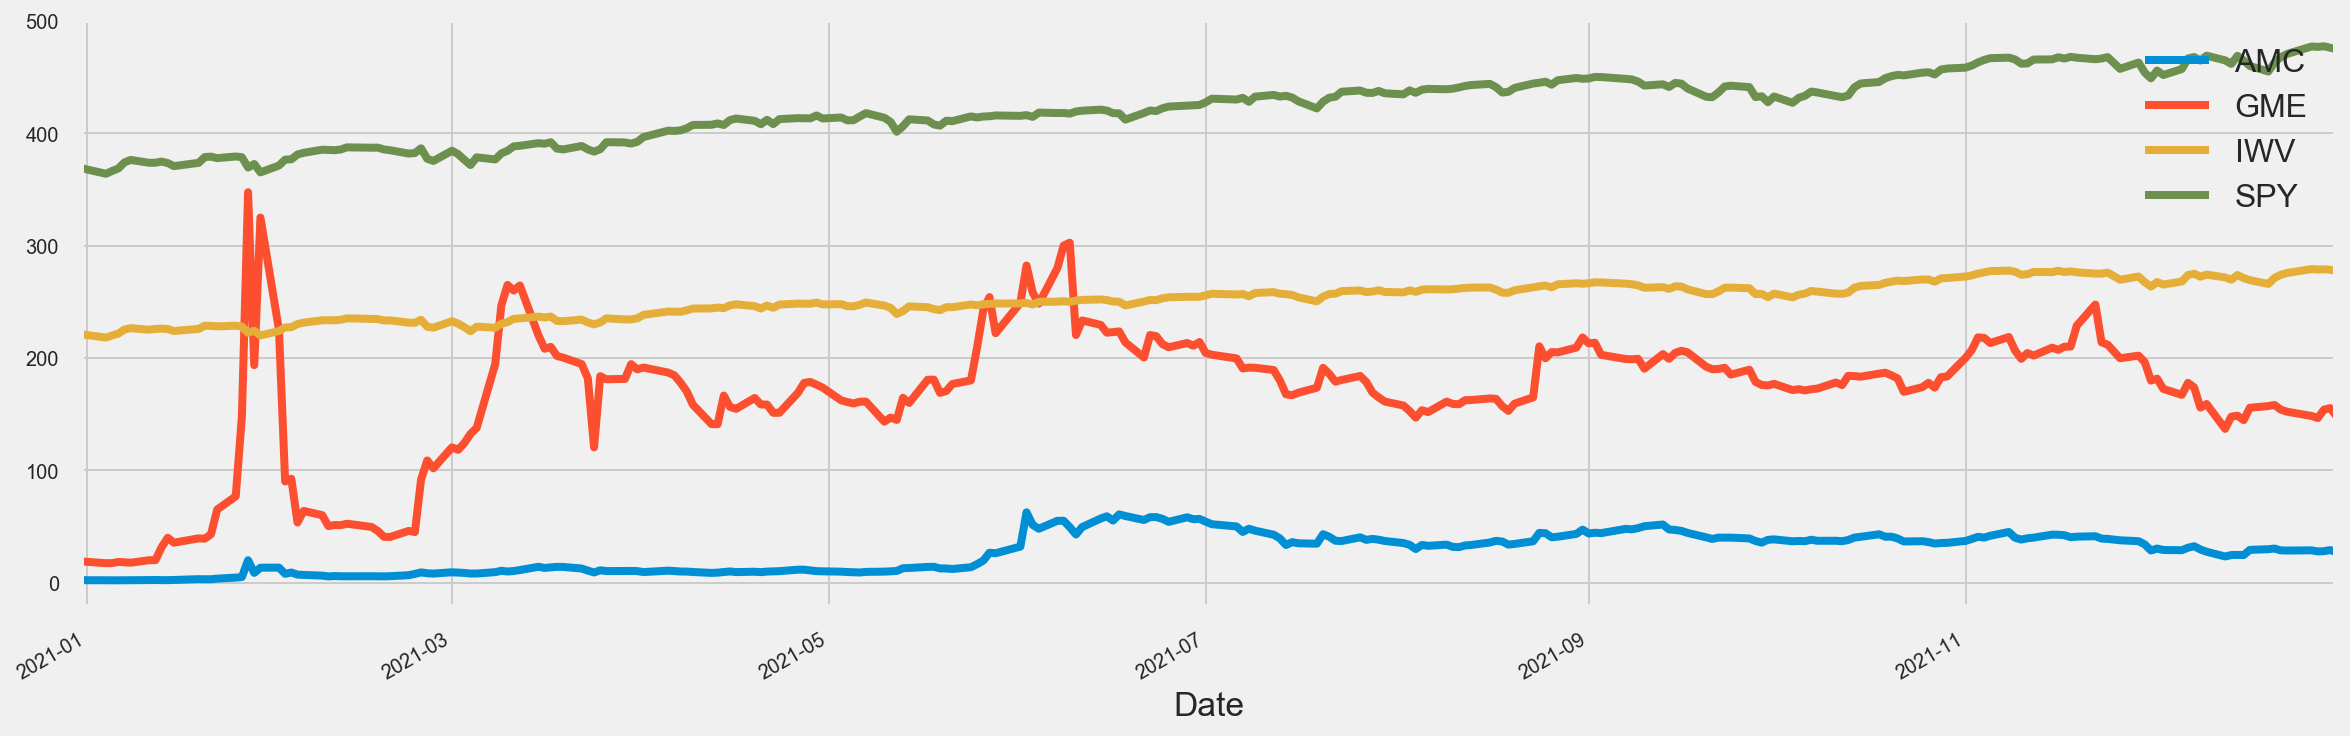

In [783]:
plt.figure()
df_price.plot(legend=True, figsize=(18,6))
plt.show()

### Calculating the daily returns

However, the scaling of the respective prices can be an issues for comparisons. We want to normalize all the price data to daily returns.

In [784]:
df_daily_returns = df_price.pct_change()
df_daily_returns
# we will keep the first NA row for the cumulative returns

,AMC,GME,IWV,SPY
Date,,,,
2020-12-31,NaN,NaN,NaN,NaN
2021-01-04,-0.051887,-0.084395,-0.013241,-0.013614
2021-01-05,-0.014925,0.006957,0.008477,0.006887
2021-01-06,0.015152,0.056995,0.007687,0.005979
2021-01-07,0.019900,-0.015251,0.016371,0.014858
...,...,...,...,...
2021-12-27,0.006311,-0.025174,0.012736,0.014152
2021-12-28,-0.034146,-0.012474,-0.001505,-0.000817
2021-12-29,0.008297,0.051004,0.000789,0.001279


<Figure size 432x288 with 0 Axes>

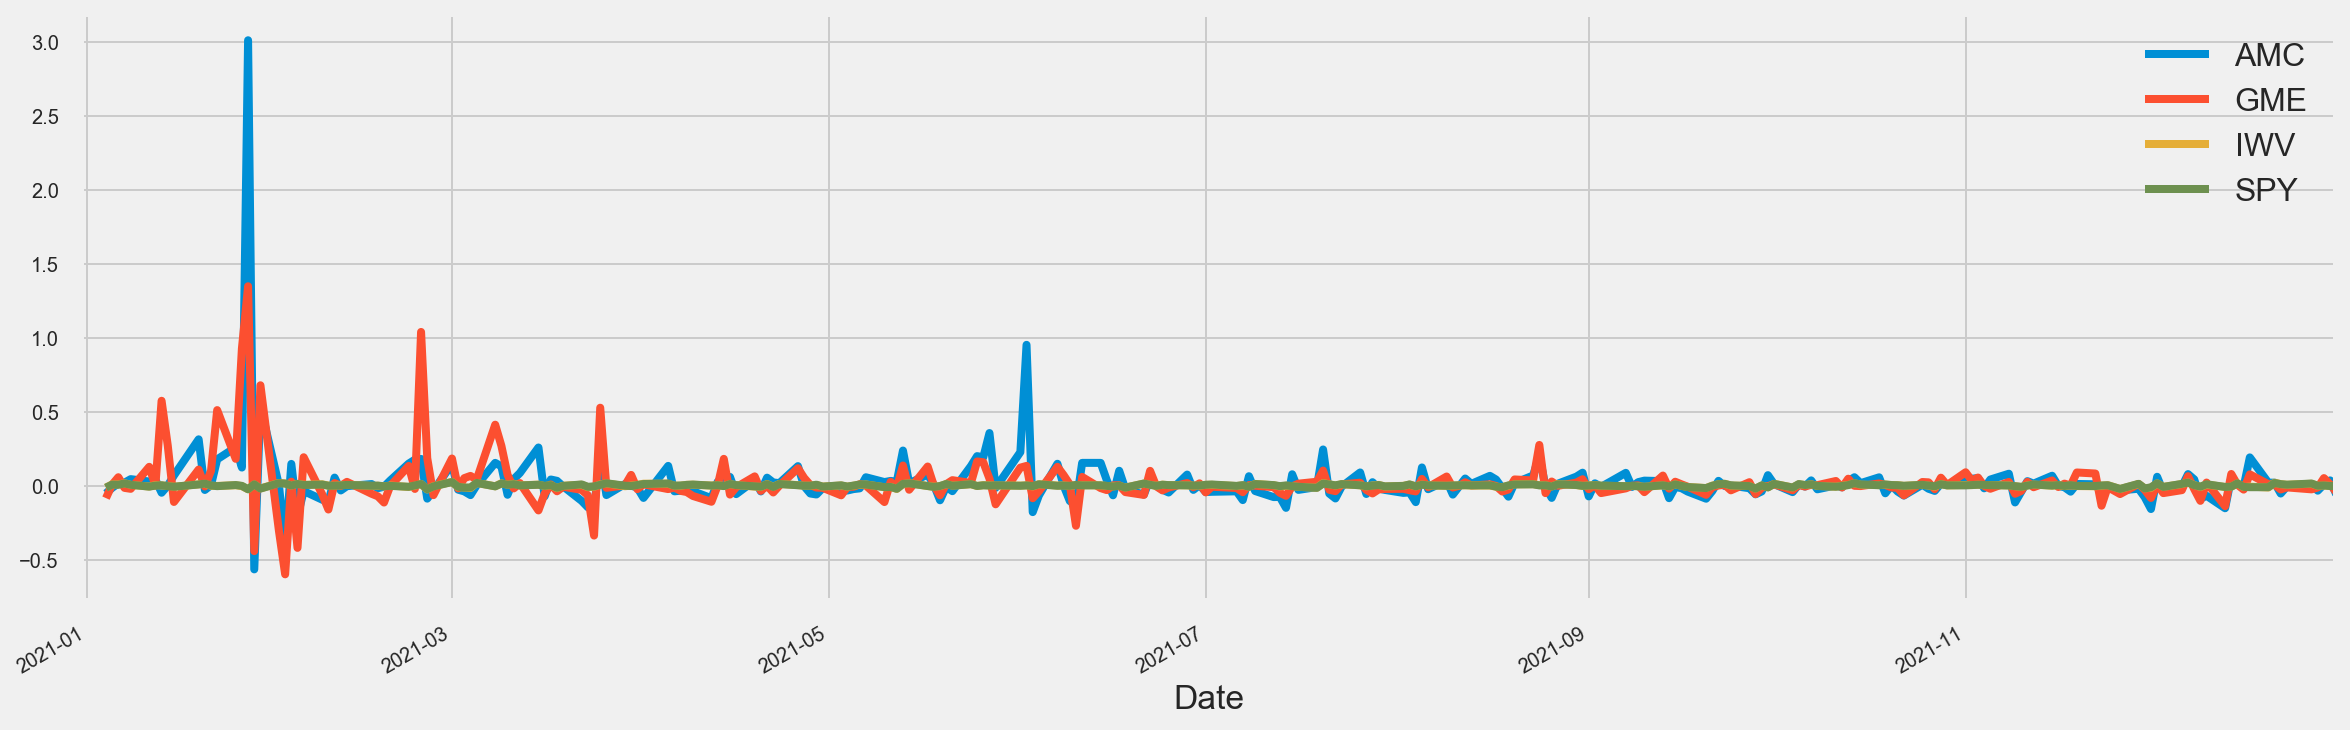

In [785]:
plt.figure()
df_daily_returns.plot(legend=True, figsize=(18,6))
plt.show()

We can clearly see the return outliers for AMC and GME. 

Let's take a look at the distribution of the daily returns for AMC and GME.

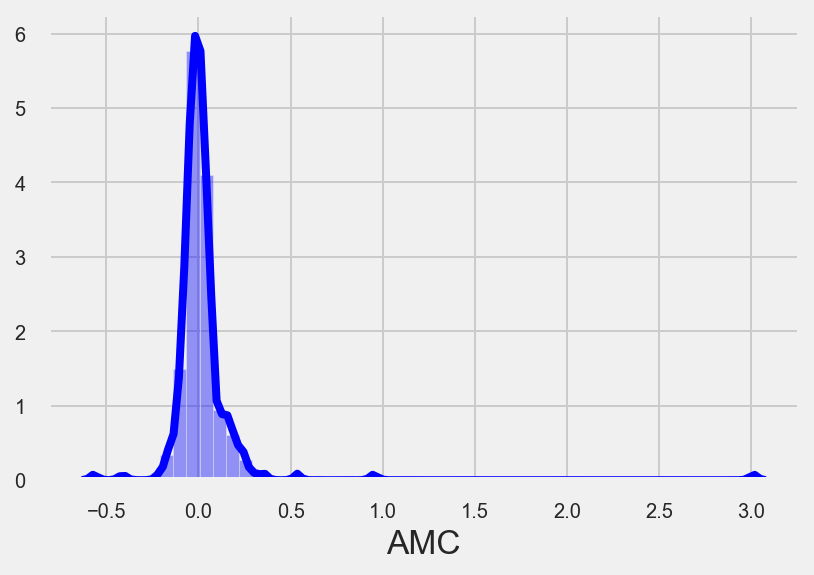

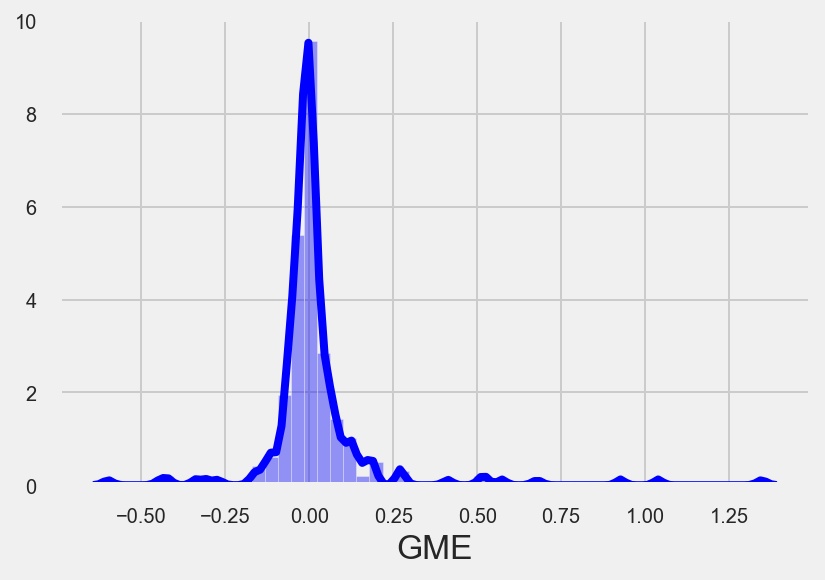

In [786]:
sns.distplot(df_daily_returns.dropna()['AMC'], bins=50, color='blue')
plt.show()
sns.distplot(df_daily_returns.dropna()['GME'], bins=50, color='blue')
plt.show()

It appears that positive returns were more common than negative for both stocks. For AMC, we can see that there is a long positive tail that holds the large positive return outliers. GME exhibits a similar tail, but more subdued.

### Calculating the cumulative returns

In order to best compare the stocks and indices, we will want to show their respective growth from $1. For this we will need the levels, or cumulative returns.

In [787]:
df_cum_daily_returns = (1 + df_daily_returns).cumprod() - 1

# We will add 1 as the starting point for 12/31/2020.
df_cum_daily_returns.iloc[0,:] = 0
df_cum_daily_returns.iloc[:,:] += 1

df_cum_daily_returns

,AMC,GME,IWV,SPY
Date,,,,
2020-12-31,1.000000,1.000000,1.000000,1.000000
2021-01-04,0.948113,0.915605,0.986759,0.986386
2021-01-05,0.933962,0.921975,0.995124,0.993180
2021-01-06,0.948113,0.974522,1.002773,0.999117
2021-01-07,0.966981,0.959660,1.019190,1.013962
...,...,...,...,...
2021-12-27,13.537737,7.872080,1.262664,1.293521
2021-12-28,13.075472,7.773886,1.260764,1.292464
2021-12-29,13.183963,8.170382,1.261759,1.294118


### Graphing the growth of $1

<Figure size 432x288 with 0 Axes>

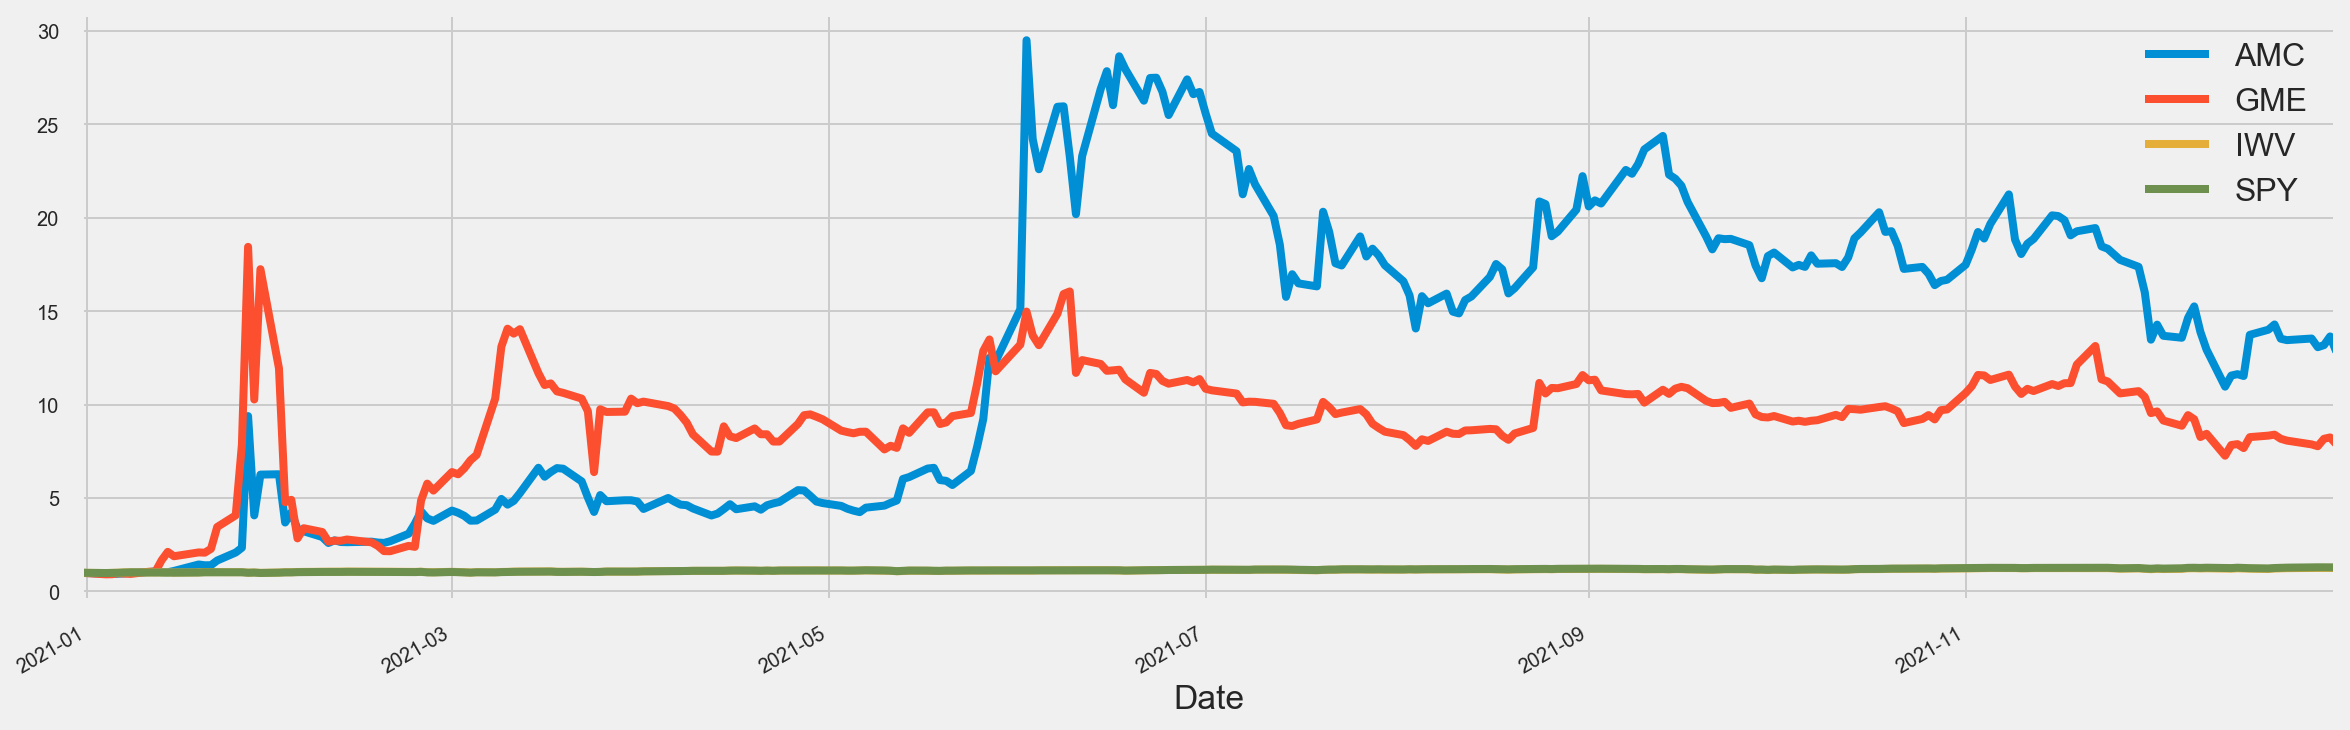

In [788]:
plt.figure()
df_cum_daily_returns.plot(legend=True, figsize=(18,6))
plt.show()

As the scale is still blown out by the meme stocks, we will seperate them from the indices.

### Meme stocks - Growth of $1

<Figure size 432x288 with 0 Axes>

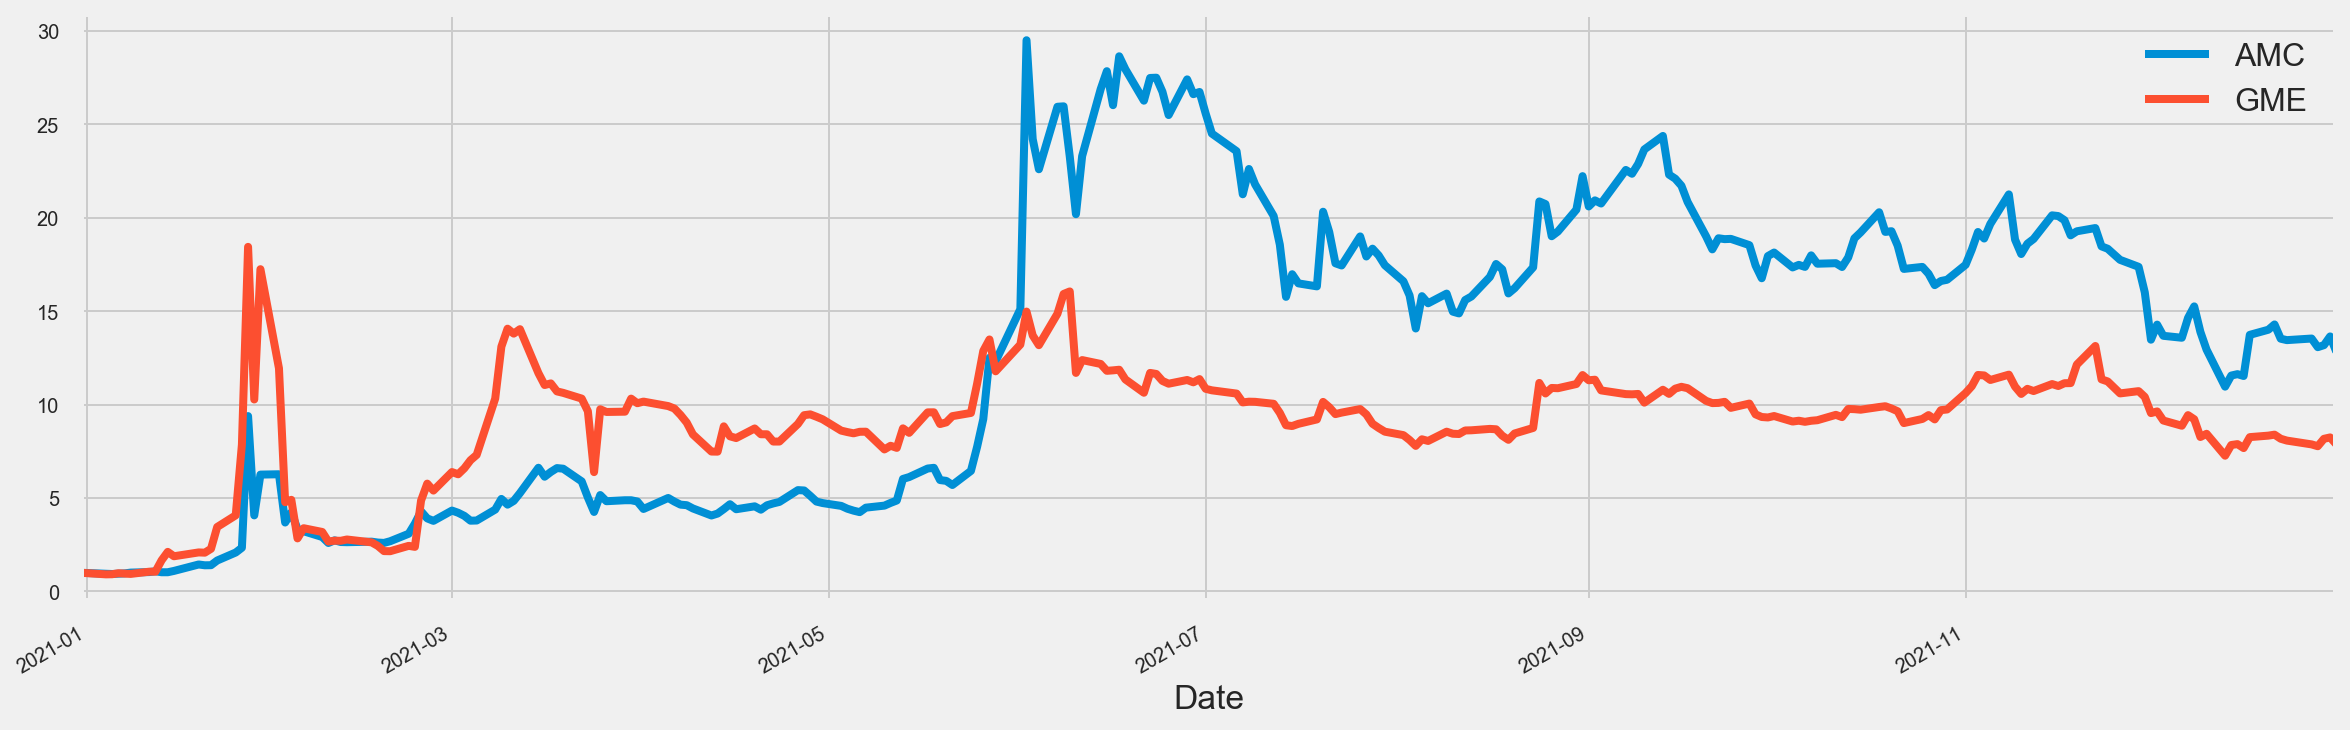

In [789]:
plt.figure()
df_cum_daily_returns.iloc[:,0:2].plot(legend=True, figsize=(18,6))
plt.show()

### Indices - Growth of $1

<Figure size 432x288 with 0 Axes>

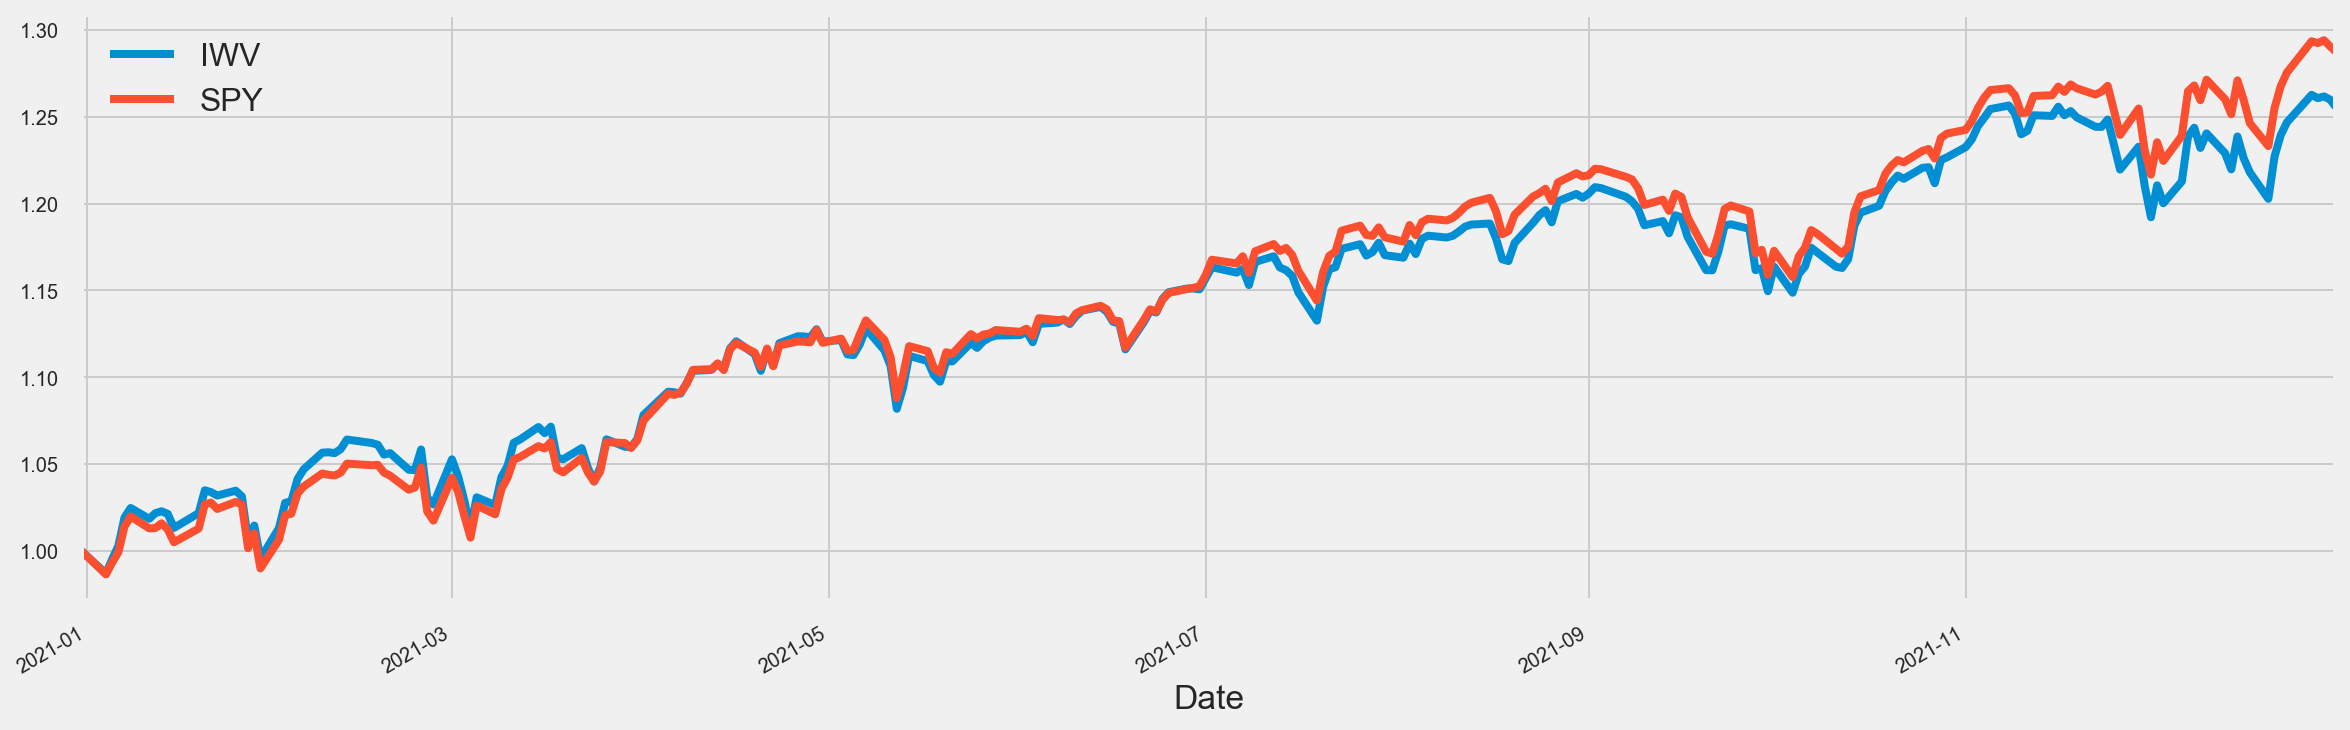

In [790]:
plt.figure()
df_cum_daily_returns.iloc[:,2:4].plot(legend=True, figsize=(18,6))
plt.show()

## Analysis of stock volume

In [791]:
df_volume = df.pivot_table(index=['Date'], columns='Ticker', values=['Volume'])
# Remove the terms "Ticker" and "Volume" from the df columns
df_volume.columns = [col[1] for col in df_volume.columns.values]
df_volume

,AMC,GME,IWV,SPY
Date,,,,
2020-12-31,28234300.0,6922700.0,165300.0,78520700.0
2021-01-04,29873800.0,10022500.0,458000.0,110210800.0
2021-01-05,28148300.0,4961500.0,844200.0,66426200.0
2021-01-06,67363300.0,6056200.0,306100.0,107997700.0
2021-01-07,26150500.0,6129300.0,345300.0,68766800.0
...,...,...,...,...
2021-12-27,30785600.0,1613600.0,222700.0,56808600.0
2021-12-28,31588100.0,1331100.0,170000.0,47274600.0
2021-12-29,30983400.0,2037400.0,242200.0,54503000.0


<Figure size 432x288 with 0 Axes>

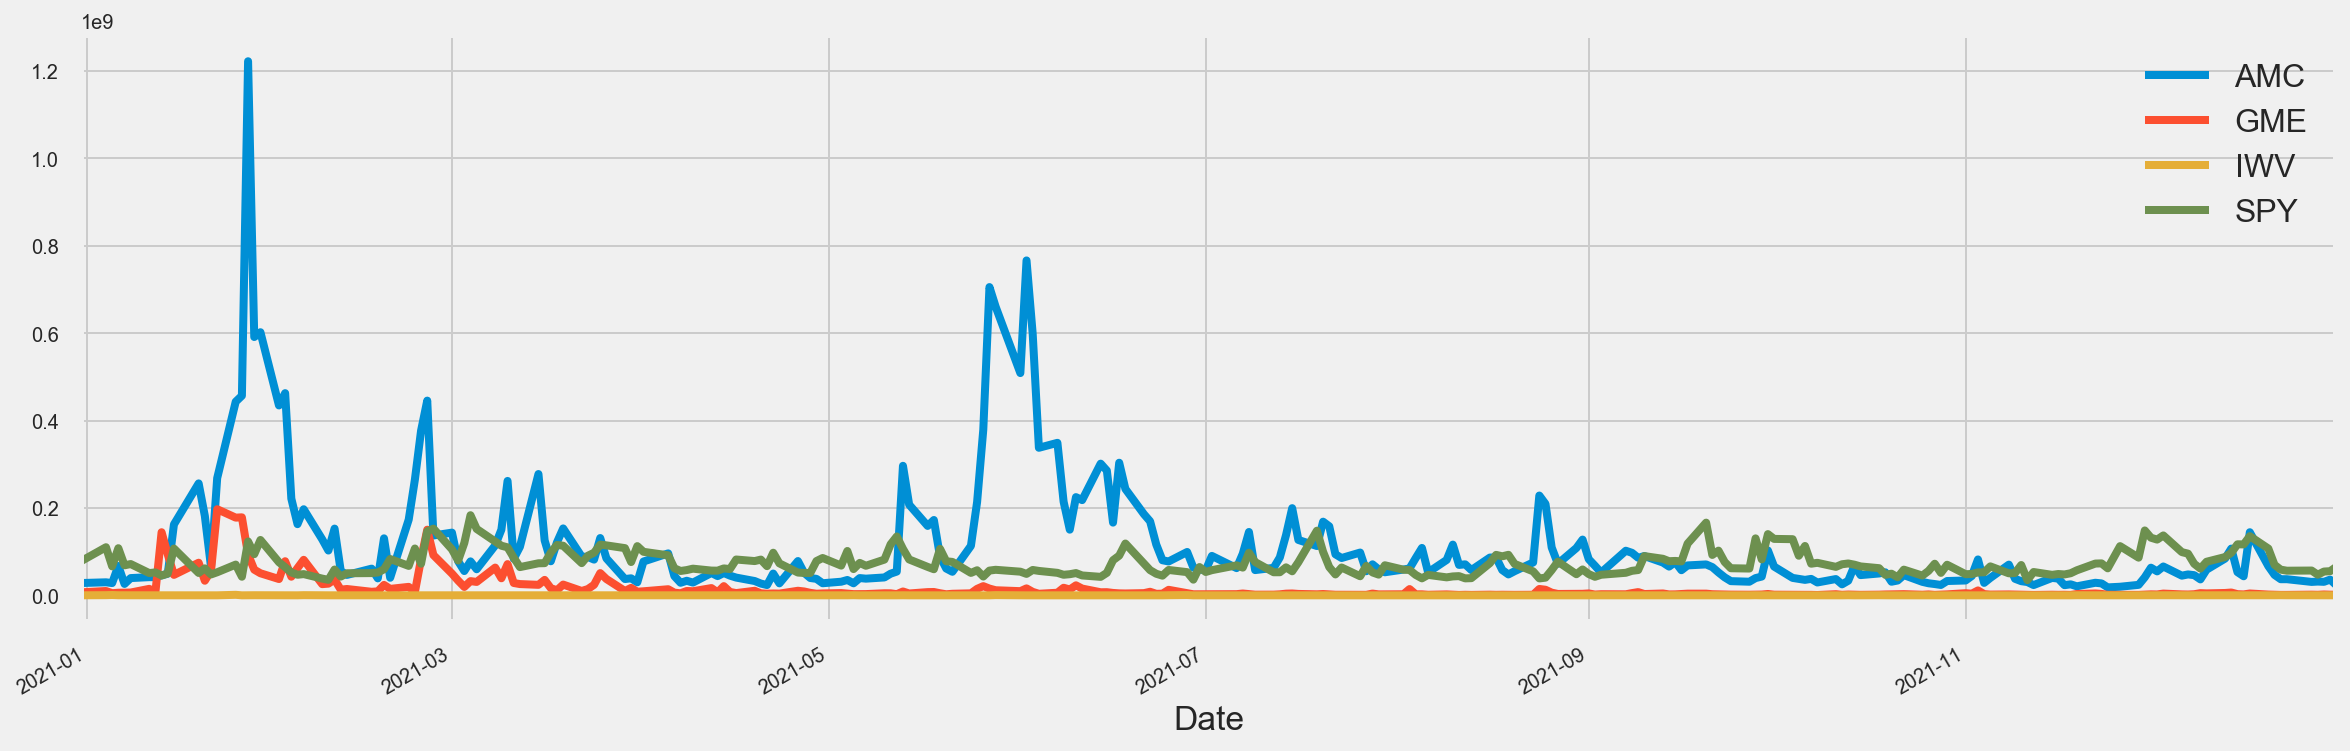

In [792]:
plt.figure()
df_volume.plot(legend=True, figsize=(18,6))
plt.show()

As we can see, there was enormous trading volume for the meme stocks, which often surpassed the S&P 500 volume.  

## Calculating the 30 day moving average

In [793]:
df_moving_avg_30 = df_price.rolling(window=60, center=False).mean()
df_moving_avg_30.dropna()

,AMC,GME,IWV,SPY
Date,,,,
2021-03-29,7.467000,113.963001,229.406801,380.197636
2021-03-30,7.604167,116.890001,229.626880,380.561830
2021-03-31,7.740833,119.766167,229.912766,381.036141
2021-04-01,7.863833,122.667501,230.218910,381.539302
2021-04-05,8.007167,125.477334,230.546296,382.100832
...,...,...,...,...
2021-12-27,35.706167,183.932166,269.722222,456.485494
2021-12-28,35.527167,183.424666,270.080084,457.221332
2021-12-29,35.380167,183.134166,270.496782,458.060342


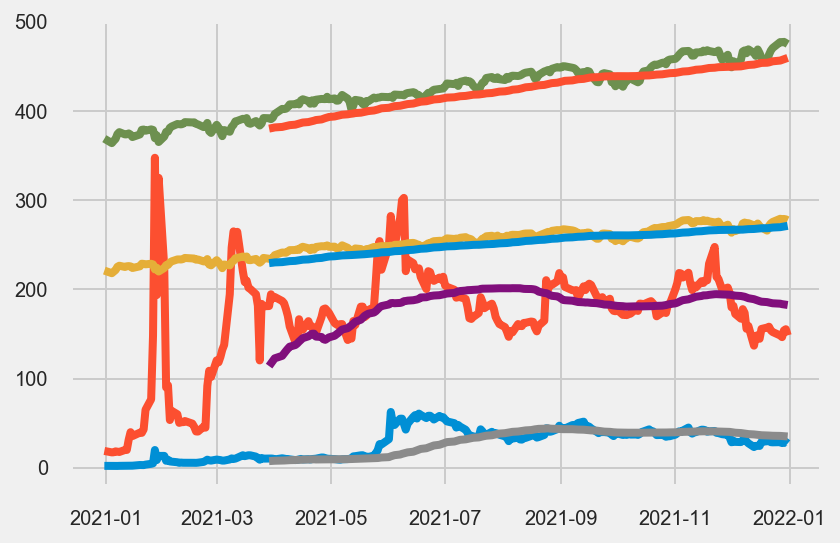

In [794]:
plt.figure()
plt.plot(df_price)
plt.plot(df_moving_avg_30)
plt.figsize=(18,6)
plt.show()

## Correlation between daily returns of the meme stocks and the indices

In [795]:
df_daily_returns = df_daily_returns.dropna()
df_daily_returns

,AMC,GME,IWV,SPY
Date,,,,
2021-01-04,-0.051887,-0.084395,-0.013241,-0.013614
2021-01-05,-0.014925,0.006957,0.008477,0.006887
2021-01-06,0.015152,0.056995,0.007687,0.005979
2021-01-07,0.019900,-0.015251,0.016371,0.014858
2021-01-08,0.043903,-0.021571,0.005311,0.005698
...,...,...,...,...
2021-12-27,0.006311,-0.025174,0.012736,0.014152
2021-12-28,-0.034146,-0.012474,-0.001505,-0.000817
2021-12-29,0.008297,0.051004,0.000789,0.001279


First, we will look at the correlation of AMC's daily returns with GME's daily returns. We will create scatterplots to visualize the correlations. 

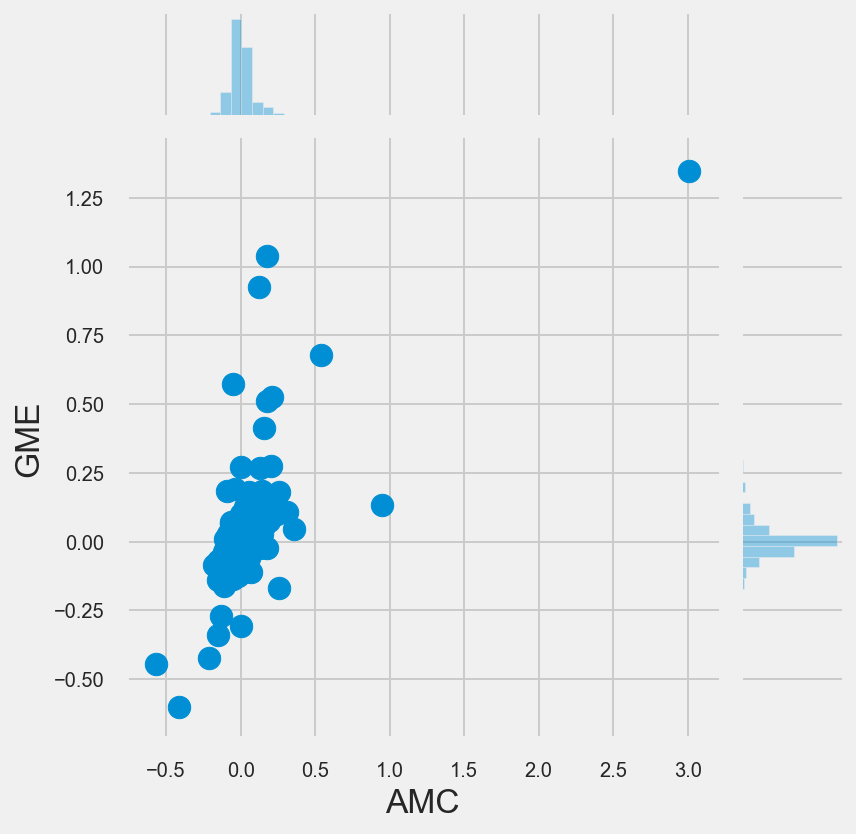

In [796]:
sns.jointplot('AMC', 'GME', df_daily_returns,kind='scatter')
plt.show()

There does not seem to be a strong linear relationship between the stocks. For reference, let's look at the correlation between the indices.

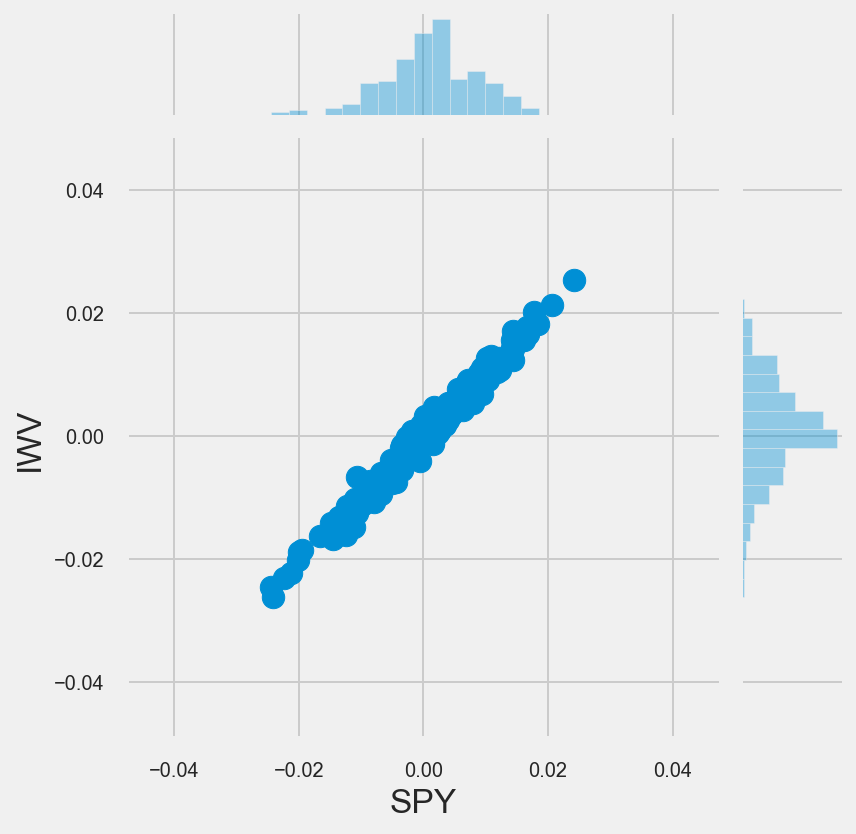

In [797]:
sns.jointplot('SPY', 'IWV', df_daily_returns,kind='scatter')
plt.show()

As expected, the relationship is close to linear as the two indices overlap in holdings and their price movements are driven by similar factors. Now, let's take a look at AMC and SPY.

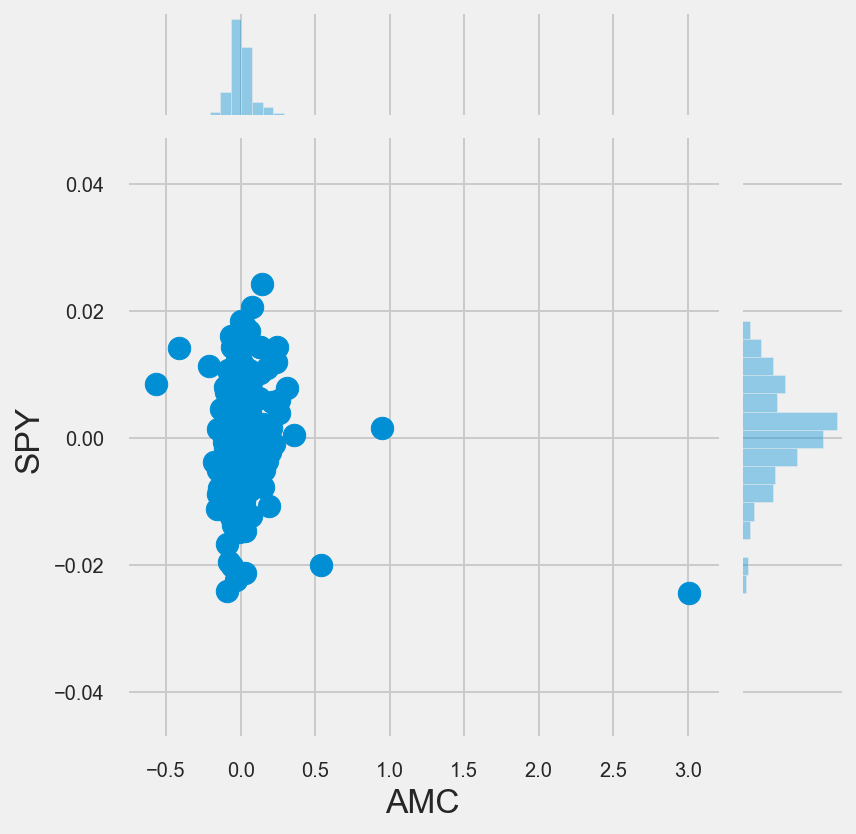

In [798]:
sns.jointplot('AMC', 'SPY', df_daily_returns,kind='scatter')
plt.show()

As expected, there does not seem to a close correlation at all between AMC and the market.

## How can we use the historical returns and volume to try to predict the future?

We will use a simple linear analysis machine learning model to try to predict AMC stock prices based on its trading volume. Given the meme stocks are inherently outliers, we should keep in mind that external factors, such as Reddit activity or earning reports, may be better indicators.

#### Preparing the data 

In [799]:
# Output is daily returns
df_y = pd.DataFrame(df_daily_returns['AMC'])
y = np.array(df_y)

# skip first Volume value as NA for daily returns
df_X = pd.DataFrame(df_volume['AMC'])[1:]
X = np.array(df_X) 

# dates for visualizing results
dates = np.array(pd.DataFrame(df['Date']))

#### Separating 20% of data for testing

In [800]:
forecast_out = int(math.ceil(0.2 * len(df_X)))
forecast_out

51

In [801]:
# Testing, only holds the last 51 dates.
X_test = X[-forecast_out:]
y_test = y[-forecast_out:]

# Training, omits the last 26 dates.
X_train = X[:-forecast_out]
y_train = y[:-forecast_out]

# Dates for graphing results
dates_test = dates[-forecast_out:]

#### Run the linear regression

In [802]:
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Resulting value for the linear relationship found

In [803]:
linreg.coef_

array([[9.4302933e-10]])

In [804]:
y_pred = linreg.predict(X_test)

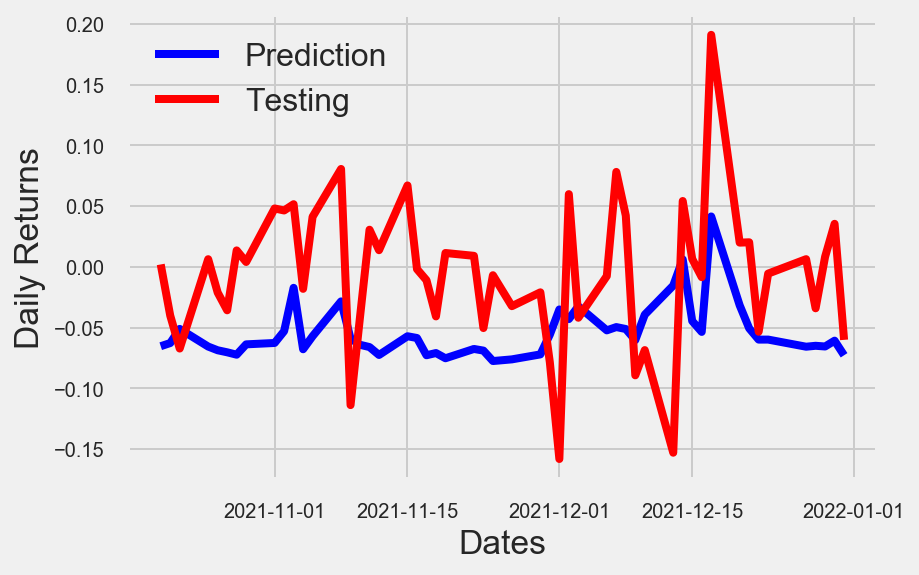

In [805]:
plt.figure()
plt.plot(dates_test, y_pred,'blue',label="Prediction")
plt.plot(dates_test, y_test,'red', label="Testing")
plt.gca().legend()
plt.xlabel('Dates')
plt.ylabel('Daily Returns')
plt.show()

We can infer from the result that AMC's volume is not a great linear predictor for its daily returns.